# Stippling Application 

The PyTSPArt repo is cloned in order to access the adapted code for the stippling algorithm.

In [ ]:
!git clone https://github.com/RoboTums/PyTSPArt.git
!mv PyTSPArt/code/voronoi.py .

Cloning into 'PyTSPArt'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 393 (delta 0), reused 0 (delta 0), pack-reused 390
Receiving objects: 100% (393/393), 159.87 MiB | 36.75 MiB/s, done.
Resolving deltas: 100% (184/184), done.


The base image is asked for to the user.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1_pWeHwkrkGWZcEQMgNEygPQ.jpeg to 1_pWeHwkrkGWZcEQMgNEygPQ.jpeg


The following snippet of code shows the image uploaded.

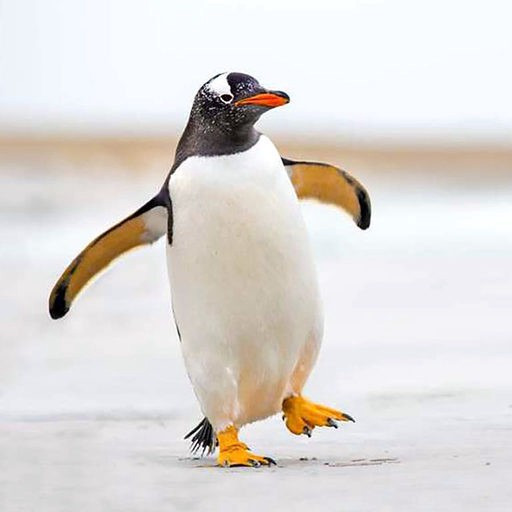

In [ ]:
from IPython.display import Image
Image(filename=list(uploaded.keys())[0]) 

Stippling algorithm, recieves a base image and parameters such as, number of points and number of iterations, in order to process the image given.

In [ ]:
# This code was adapted from: https://github.com/RoboTums/PyTSPArt/blob/master/code/stippler.py
#! /usr/bin/env python3
# -----------------------------------------------------------------------------
# Weighted Voronoi Stippler
# Copyright (2017) Nicolas P. Rougier - BSD license
#
# Implementation of:
#   Weighted Voronoi Stippling, Adrian Secord
#   Symposium on Non-Photorealistic Animation and Rendering (NPAR), 2002
# -----------------------------------------------------------------------------
# Some usage examples
#
# stippler.py boots.jpg --save --force --n_point 20000 --n_iter 50
#                       --pointsize 0.5 2.5 --figsize 8 --interactive
# stippler.py plant.png --save --force --n_point 20000 --n_iter 50
#                       --pointsize 0.5 1.5 --figsize 8
# stippler.py gradient.png --save --force --n_point 5000 --n_iter 50
#                          --pointsize 1.0 1.0 --figsize 6
# -----------------------------------------------------------------------------
# usage: stippler.py [-h] [--n_iter n] [--n_point n] [--epsilon n]
#                    [--pointsize min,max) (min,max] [--figsize w,h] [--force]
#                    [--save] [--display] [--interactive]
#                    image filename
#
# Weighted Vororonoi Stippler
#
# positional arguments:
#   image filename        Density image filename
#
# optional arguments:
#   -h, --help            show this help message and exit
#   --n_iter n            Maximum number of iterations
#   --n_point n           Number of points
#   --epsilon n           Early stop criterion
#   --pointsize (min,max) (min,max)
#                         Point mix/max size for final display
#   --figsize w,h         Figure size
#   --force               Force recomputation
#   --save                Save computed points
#   --display             Display final result
#   --interactive         Display intermediate results (slower)
# -----------------------------------------------------------------------------
import tqdm
import voronoi
import os.path
import scipy.misc
import scipy.ndimage
import numpy as np
import imageio
import matplotlib.pyplot as plt

def normalize(D):
    Vmin, Vmax = D.min(), D.max()
    if Vmax - Vmin > 1e-5:
        D = (D-Vmin)/(Vmax-Vmin)
    else:
        D = np.zeros_like(D)
    return D


def initialization(n, D):
    """
    Return n points distributed over [xmin, xmax] x [ymin, ymax]
    according to (normalized) density distribution.
    with xmin, xmax = 0, density.shape[1]
         ymin, ymax = 0, density.shape[0]
    The algorithm here is a simple rejection sampling.
    """

    samples = []
    while len(samples) < n:
        # X = np.random.randint(0, D.shape[1], 10*n)
        # Y = np.random.randint(0, D.shape[0], 10*n)
        X = np.random.uniform(0, D.shape[1], 10*n)
        Y = np.random.uniform(0, D.shape[0], 10*n)
        P = np.random.uniform(0, 1, 10*n)
        index = 0
        while index < len(X) and len(samples) < n:
            x, y = X[index], Y[index]
            x_, y_ = int(np.floor(x)), int(np.floor(y))
            if P[index] < D[y_, x_]:
                samples.append([x, y])
            index += 1
    return np.array(samples)

def stippler(filename,
            n_point = 5000,
            n_iter = 50,
            threshold = 255,
            force = False,
            save = False,
            display = False,
            interactive = False):

    density = imageio.imread(filename, as_gray=True, pilmode='L')

    # We want (approximately) 500 pixels per voronoi region
    zoom = (n_point * 500) / (density.shape[0]*density.shape[1])
    zoom = int(round(np.sqrt(zoom)))
    density = scipy.ndimage.zoom(density, zoom, order=0)
    # Apply threshold onto image
    # Any color > threshold will be white
    density = np.minimum(density, threshold)

    density = 1.0 - normalize(density)
    density = density[::-1, :]
    density_P = density.cumsum(axis=1)
    density_Q = density_P.cumsum(axis=1)

    dirname = os.path.dirname(filename)
    basename = (os.path.basename(filename).split('.'))[0]
    pdf_filename = os.path.join(dirname, basename + "_stipple.pdf")
    png_filename = os.path.join(dirname, basename + "_stipple.png")
    dat_filename = os.path.join(dirname, basename + "_stipple.npy")

    # Initialization
    points = initialization(n_point, density)
    print("Nb points:", n_point)
    print("Nb iterations:", n_iter)

    print("Density file: %s (resized to %dx%d)" % (
          filename, density.shape[1], density.shape[0]))

    for i in tqdm.trange(n_iter):
        regions, points = voronoi.centroids(points, density, density_P, density_Q)
       
    return points, density

    # Plot voronoi regions if you want
    # for region in vor.filtered_regions:
    #     vertices = vor.vertices[region, :]
    #     ax.plot(vertices[:, 0], vertices[:, 1], linewidth=.5, color='.5' )

In [ ]:
points, density = stippler(list(uploaded.keys())[0], n_point=1000)

Nb points: 1000
Nb iterations: 50
Density file: 1_pWeHwkrkGWZcEQMgNEygPQ.jpeg (resized to 512x512)


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Converts the result of the stippler algorithm to a list of points.

In [ ]:
points1 = points.tolist()
#points1

In [ ]:
class ImagePoints:
    def __init__(self, point_list):
        '''
        point_list: list of points returned by the stippler algorithm
        '''
        self.point_list = point_list

    def read_list(self):
        '''
        Returns:
        The complete list of points
        '''
        return self.point_list

    def read(self, i):
        '''
        i: index of the point to read
        Returns:
        The point in position i
        '''
        return self.point_list[i]
    
    def update(self, point, i):
        '''
        point: given point
        i: index of the point to read
        Returns:
        Updates the point in position i
        '''
        self.point_list[i] = point
    
    def insert(self, point):
        '''
        point: a given point
        Returns:
        Inserts a given point at the back of the list
        '''
        self.point_list.append(point)

    def num_points(self):
        '''
        Returns:
        The number of elements in the list
        '''
        return len(self.point_list)

    def delete(self, i):
        '''
        i: index of the point to read
        Returns:
        Deletes the point in position i
        '''
        self.point_list.pop(i)

    def visualize(self, density, pointsize = (1.0, 1.0), figsize = 6):
        '''
        Density: density of the points in the image
        Pointsize: size of the points that will conform the processed image
        Figsize: size of the processed image
        Returns:
        A visual representation of the processed base image
        '''
        # Visualize points
        xmin, xmax = 0, density.shape[1]
        ymin, ymax = 0, density.shape[0]
        bbox = np.array([xmin, xmax, ymin, ymax])
        ratio = (xmax-xmin)/(ymax-ymin)
        
        fig = plt.figure(figsize=(figsize, figsize/ratio),
                        facecolor="white")
        ax = fig.add_axes([0, 0, 1, 1], frameon=False)
        ax.set_xlim([xmin, xmax])
        ax.set_xticks([])
        ax.set_ylim([ymin, ymax])
        ax.set_yticks([])
        points = np.array(self.point_list)
        scatter = ax.scatter(points[:, 0], points[:, 1], s=1, 
                            facecolor="k", edgecolor="None")
        Pi = points.astype(int)
        X = np.maximum(np.minimum(Pi[:, 0], density.shape[1]-1), 0)
        Y = np.maximum(np.minimum(Pi[:, 1], density.shape[0]-1), 0)
        sizes = (pointsize[0] +
                (pointsize[1]-pointsize[0])*density[Y, X])
        scatter.set_offsets(points)
        scatter.set_sizes(sizes)

        plt.show()




In [ ]:
Image1 = ImagePoints(points1)
print(Image1.read(2))
Image1.delete(2)
print(Image1.read(2))
print(Image1.num_points())
Image1.insert([0, 1])
print(Image1.num_points())
#Image1.delete(4998)
print(Image1.num_points())

[772.261091079574, 802.9851571594878]
[726.0456865416058, 818.4029541689674]
1999
2000
2000


Visualization of the points returned by the algorithm within the density parameters givien.

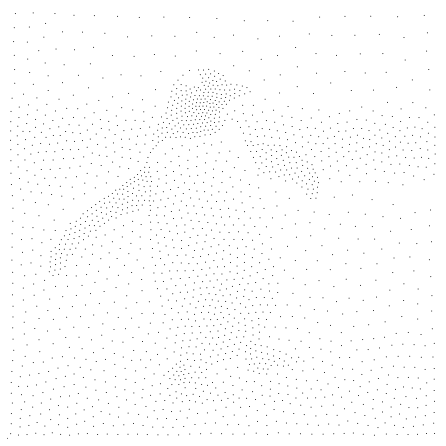

In [ ]:
Image1.visualize(density)

In [ ]:
import math

points = [[4,1], [4,2], [4,3], 
          [3,1], [3,2], [3,3], 
          [2,1], [2,2], [2,3], 
          [1,1], [1,2], [1,3]]

def distance(point1, point2):
    return math.sqrt(((point2[0] - point1[0])**2) + ((point2[1] - point1[1])**2))

def k_neighbors(i, points, k):
    """
    i: index of a point
    points: list of points
    k: number of neighbors
    """
    distancias_point_i = []
    point_i = points[i]
    size = len(points)
    j = 0
    while j < size:
        point_j = points[j]
        distancias_point_i.append([distance(point_i, point_j), j])
        j += 1
    distancias_point_i.sort()
    #print(distancias_point_i)
    result = []
    for m in range(len(distancias_point_i)):
        result.append(distancias_point_i[m][1])
    return result[1:k+1]

#print(distance([1,2], [3,4]))
print(k_neighbors(3, points, 5))

class Graph():
    def __init__(self):
        self.V = []
        self.E = []

    def add_vertex(self, info):
        self.V.append(info)
        self.E.append([])

    def add_edge(self, start, finish):
        self.E[start].append(finish)

    #def get_vertex(self, i):

    #def get_neighbors(self, i):

    #def delete_vertex():

    #def delete_edge():

    def print(self):
        print(self.V)
        print(self.E)


""" graph1 = Graph()
graph1.add_vertex(0)
graph1.add_vertex(1)
graph1.add_vertex(2)
graph1.add_vertex(3)
graph1.add_vertex(4)
graph1.add_vertex(5)
graph1.add_vertex(6)
graph1.add_vertex(7)
graph1.add_edge(1, 2)
graph1.add_edge(2, 4)
graph1.add_edge(3, 1)
graph1.add_edge(3, 4)
graph1.add_edge(4, 5)
graph1.add_edge(4, 7)
graph1.add_edge(6, 7)
graph1.add_edge(5, 6)
graph1.print() """

def create_nn_graph(points, k):
    nn_graph = Graph()
    j = 0
    size = len(points)
    while j < size:
        nn_graph.add_vertex(points[j])
        neighbors = k_neighbors(j, points, k)
        for n in range(len(neighbors)):
            nn_graph.add_edge(j, neighbors[n])
        j += 1
    return nn_graph

graph = create_nn_graph(points, 3)
graph.print()





